In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

In [2]:
%matplotlib notebook

CRU removed from precipitations datasets because it is too far from other products

In [3]:
list_data_P=['CPC','CRU','ERA5_Land','GPCC','GPCP','GPM','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','GLEAM','MERRA2','MOD16','SSEBop',
              'GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
              #'GLDAS22_CLSM25'
              ]
list_data_R=['ERA5_Land','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
             'GLDAS22_CLSM25',
             'GRUN','MERRA2']
list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons','GRACE_CSR_grid']

list_data={'P':list_data_P,
          'ET':list_data_ET,
          'R':list_data_R,
          'TWS':list_data_TWS}

dict_hydro_var_name={'P':'precipitations',
                    'ET':'evapotranspiration',
                    'R':'runoff',
                    'TWS':'TWS'}

In [4]:
basins=load_basins_data()

In a given basin, plot all available datasets for one hydrological variable.

<IPython.core.display.Javascript object>


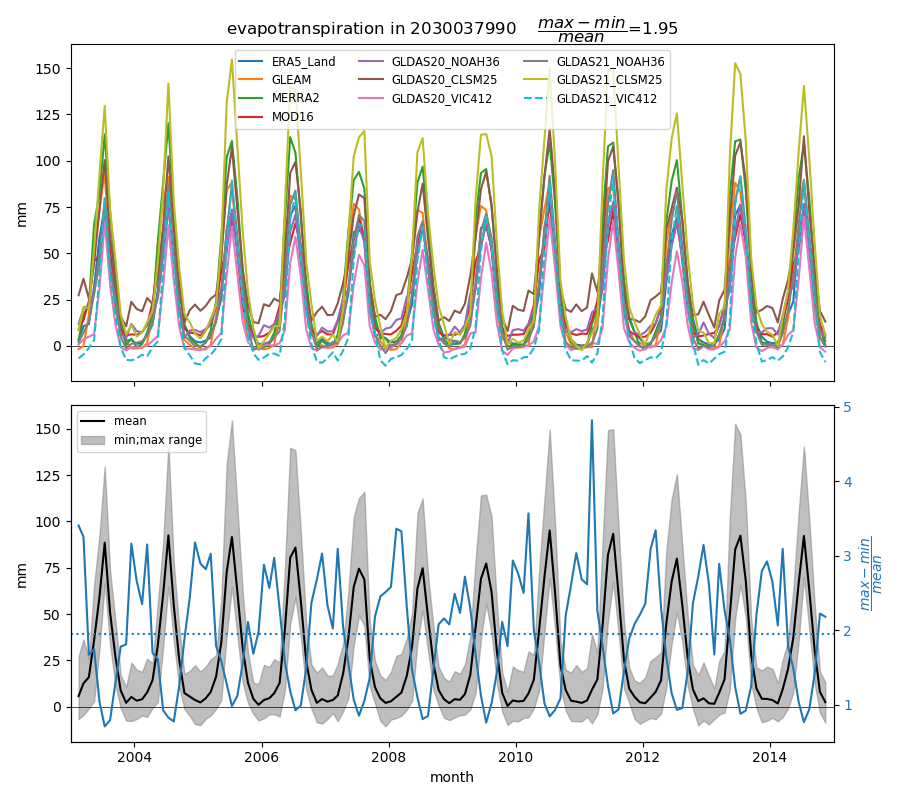

nans for SSEBop


<IPython.core.display.Javascript object>


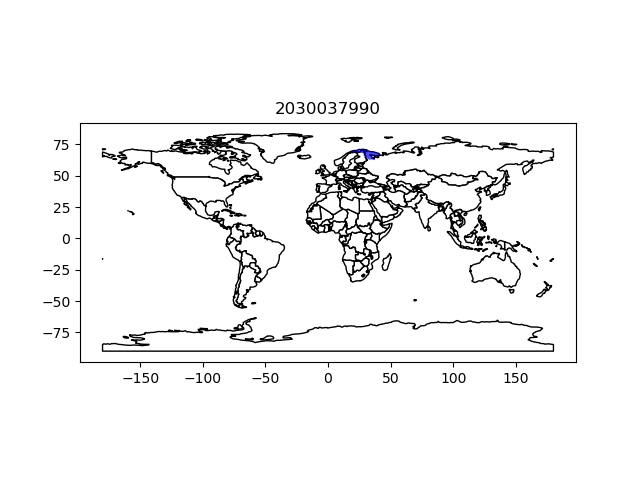

In [5]:
#basin_name=basins.index[np.random.randint(basins.shape[0])]
basin_name=2030037990

hydro_var_name='ET'
hydro_var_long_name=dict_hydro_var_name[hydro_var_name]

time_idx=pd.date_range(date(2003,2,1),date(2014,12,1),freq='SM')[::2]

hydro_mean=np.zeros_like(time_idx,dtype=float)
hydro_max=np.zeros_like(time_idx,dtype=float)
hydro_min=300*np.ones_like(time_idx,dtype=float)

#plt.figure(figsize=(9,8))
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True,figsize=(9,8))
ax1.plot([date(2003,1,1),date(2015,1,1)],[0,0],'k',linewidth=0.5)

len_data=len(list_data[hydro_var_name])
for i,data in enumerate(list_data[hydro_var_name]):
    if i>9:
        l_style='--'
    else:
        l_style='-'
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data),index_col=[0])
    hydro_selec=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]]
    
    if np.sum(np.isnan(hydro_selec.values))==0:    
        hydro_mean+=hydro_selec.values
        hydro_max=np.where(hydro_selec.values>hydro_max,hydro_selec.values,hydro_max)
        hydro_min=np.where(hydro_selec.values<hydro_min,hydro_selec.values,hydro_min)
        ax1.plot(time_idx,hydro_selec,l_style,label=data)
    else:
        len_data-=1
        print('nans for {}'.format(data))
    
#hydro_min=np.where(hydro_min<0,0,hydro_min)
hydro_mean=hydro_mean/len_data
#discr=np.mean((hydro_max-hydro_min)/hydro_mean)
discr=np.mean((hydro_max-hydro_min)/np.where(hydro_mean<10,10,hydro_mean))


ax1.set_xlim([date(2003,1,1),date(2015,1,1)])    
ax1.legend(ncol=3,fontsize='small')
ax1.set_ylabel('mm')
ax1.set_title(hydro_var_long_name+' in '+str(basin_name)+'    $\dfrac{max - min}{mean}$='+'{:.2f}'.format(discr))

ax2.plot([date(2003,1,1),date(2015,1,1)],[0,0],'k',linewidth=0.5)
ax2.fill_between(time_idx,hydro_min,hydro_max,color='grey',alpha=0.5,label='min;max range')
ax2.plot(time_idx,hydro_mean,'k',label='mean')
#ax2.plot([date(2003,1,1),date(2015,1,1)],[np.mean(hydro_mean),np.mean(hydro_mean)],'k:',label='mean(mean)')
#plt.plot(time_idx,hydro_max,'r')
#plt.plot(time_idx,hydro_min,'g')
ax2.set_xlim([date(2003,1,1),date(2015,1,1)])
ax2.set_ylabel('mm')
ax2.legend(loc='upper left',fontsize='small')
ax2.set_xlabel('month')

ax3=ax2.twinx()
#ax3.plot(time_idx,np.abs((hydro_max-hydro_min)/hydro_mean),'tab:blue')
ax3.plot(time_idx,(hydro_max-hydro_min)/np.where(hydro_mean<10,10,hydro_mean),'tab:blue')
ax3.plot([date(2003,1,1),date(2015,1,1)],[discr,discr],'tab:blue',linestyle=':')
ax3.set_ylabel('$\dfrac{max-min}{mean}$',color='tab:blue')
ax3.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()



world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_name],'geometry'].plot(ax=ax, color='blue',alpha=0.7)
plt.title(basin_name)
plt.show()
plt.show()

## Map of dispersion

In [6]:
basins=load_basins_data()
selected_basins=basins.copy()

Store the value of $\dfrac{max - min}{mean}$ for each basin and each hydrological variable.

In [7]:
hydro_var_name='ET'

discrepancy=pd.Series(np.zeros_like(selected_basins.index,dtype=float),index=selected_basins.index)
time_idx=pd.date_range(date(2003,2,1),date(2014,12,1),freq='SM')[::2]

hydro_mean=pd.DataFrame(np.zeros((selected_basins.shape[0],time_idx.shape[0])),
                        index=selected_basins.index,columns=time_idx)
hydro_max=pd.DataFrame(np.zeros((selected_basins.shape[0],time_idx.shape[0])),
                       index=selected_basins.index,columns=time_idx)
hydro_min=pd.DataFrame(300*np.ones((selected_basins.shape[0],time_idx.shape[0])),
                       index=selected_basins.index,columns=time_idx)
len_data=len(list_data[hydro_var_name])*pd.Series(np.ones(selected_basins.index.shape[0]),index=selected_basins.index)

for data in list_data[hydro_var_name]:
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data),index_col=[0])
    hydro_selec=hydro_month.loc[:,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_idx]]
    len_data.loc[np.sum(np.isnan(hydro_month),axis=1)>0]-=1
    hydro_selec=hydro_selec.loc[np.sum(np.isnan(hydro_month),axis=1)==0]    
    
    hydro_mean.loc[hydro_selec.index,:]+=hydro_selec.values    
    hydro_max.loc[hydro_selec.index,:]=np.where(hydro_selec.values>hydro_max.loc[hydro_selec.index,:],
                                                hydro_selec.values,hydro_max.loc[hydro_selec.index,:])
    hydro_min.loc[hydro_selec.index,:]=np.where(hydro_selec.values<hydro_min.loc[hydro_selec.index,:],
                                                hydro_selec.values,hydro_min.loc[hydro_selec.index,:])

# ensure positive values
#if hydro_var_name=='P' or hydro_var_name=='R':
#    new_hydro_min=np.where(hydro_min.values<0,0,hydro_min.values)
#    hydro_min=pd.DataFrame(new_hydro_min,hydro_min.index,hydro_min.columns)
    
for basin_name in selected_basins.index:
    hydro_mean.loc[basin_name]=hydro_mean.loc[basin_name]/len_data.loc[basin_name]
    discrepancy.loc[basin_name]=np.mean((hydro_max.loc[basin_name]-hydro_min.loc[basin_name])/np.where(hydro_mean.loc[basin_name]<10,10,hydro_mean.loc[basin_name]))
    
selected_basins['discrepancy {}'.format(hydro_var_name)]=discrepancy

<IPython.core.display.Javascript object>


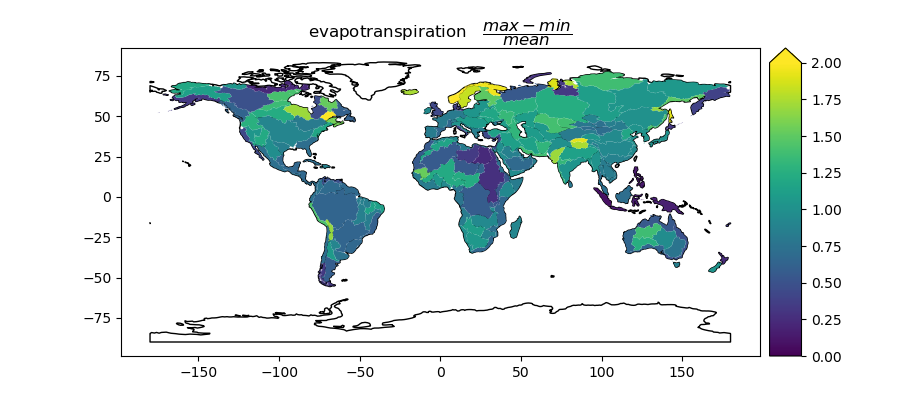

c:\users\fafal\miniconda3\lib\site-packages\geopandas\plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


In [8]:
from matplotlib.cm import ScalarMappable

hydro_var_name='ET'
hydro_var_long_name=dict_hydro_var_name[hydro_var_name]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

my_cmap = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax, color='white', edgecolor='black')
selected_basins.plot(ax=ax,column='discrepancy {}'.format(hydro_var_name),
                          legend=True,cax=cax,
                         vmin=0,
                     vmax=2.0,
                     #vmax=np.percentile(selected_basins['discrepancy {}'.format(hydro_var_name)],98),
                          missing_kwds={"color": "lightgrey",'hatch':'////'},
                          legend_kwds={#'label': "NSE",
                              'extend':'max'},
                         cmap=my_cmap, 
                     #norm=plt.Normalize(0,np.percentile(selected_basins['discrepancy {}'.format(hydro_var_name)],98))
                    )

ax.set_title(hydro_var_long_name+'   $\dfrac{max - min}{mean}$') 
plt.show()

Warning : very small values in basins with few datasets available

Show the basins with the highest disagreement between datasets

In [9]:
selected_basins.sort_values(by='discrepancy ET',ascending=False).iloc[:20]

,AREA,CLIMATE,geometry,discrepancy ET
HYBAS_ID,,,,
7030033480,234126.005883,4,"POLYGON ((-69.04167 48.75000, -69.04239 48.738...",2.261397
2030033480,232628.556261,4,"MULTIPOLYGON (((4.90833 60.79583, 4.90890 60.8...",2.144465
2030037990,331669.972861,4,"POLYGON ((38.58333 68.32500, 38.60721 68.32571...",1.954389
4030034510,75173.693845,4,"POLYGON ((142.05000 49.15833, 142.05097 49.162...",1.915415
4030050980,192052.463058,4,"POLYGON ((85.94583 36.23750, 85.94367 36.23812...",1.914734
3030000010,117753.662962,4,"MULTIPOLYGON (((70.07500 73.07500, 70.07500 73...",1.906238
2030030090,476494.626258,4,"MULTIPOLYGON (((11.10000 58.98750, 11.10085 58...",1.827450
3030003790,93754.344143,4,"MULTIPOLYGON (((82.31667 70.37500, 82.31737 70...",1.754779
4030050470,398517.928998,4,"POLYGON ((89.41250 30.25833, 89.41215 30.25591...",1.745011
